Before we start, if you want to run the notebook in parallel, you need to download trained models, dataset and logs for tensorboard.

The link for downloading: https://yadi.sk/d/sU0b3GcIZoNXNg

# VAE Improvements. 

## How to improve variational family?

Last time we spoke about ordinary VAE. We saw that it is quite a simple model and takes strong assumption on the variational family.

Specifically, it approximates the posterior distribution of latent variables as an unimodal factorized Gaussian. 
The parameters $\theta$ of the generative model are obtained optimizing the ELBO, which can lead to a poor latent representation and a generator model if the variational family is ill posed.

To address this limitation, today, we will go through some improvements, which allow us to make the variational family more expressive.

In [1]:
## First, import some models and functions we will use
from models import Base, VAE, IWAE, VAE_with_flows, VAE_MCMC
from main import make_dataloaders, get_activations
from models.samplers import HMC

## Visualization and estimation of performance
## We will estimate NLL, but sometimes this metric could be controversial https://arxiv.org/pdf/1511.01844.pdf
from utils import plot_digit_samples, plot_posterior, estimate_ll
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

## Math processing
import numpy as np
from scipy.stats import norm
import torch
import torch.nn
from torchvision.transforms import ToTensor
## Wrapper on top of PyTorch, which ease work on neural nets
import pytorch_lightning as pl
## Is there is a cuda device on the machine, lets use it!
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
## If you don't have "matplotlib widget", use "matplotlib inline" instead!!
%matplotlib inline
# %matplotlib widget

In [3]:
hidden_dim = 2  ## hidden dimension is so to ease visualization
val_batch_size = 10

First, let us load data.

As previously, we use the FashionMNIST dataset.

In [4]:
train_loader, val_loader = make_dataloaders(dataset='fashionmnist',
                                            gpus=1,
                                            batch_size=32,
                                            val_batch_size=val_batch_size)

In [5]:
act_func = get_activations()

In [6]:
def plot_pics_manifold(model):
    n = 15  # figure with 15x15 panels
    image_size = 28
    figure = np.zeros((image_size * n, image_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.tensor(np.array([[xi, yi]]), dtype=torch.float32, device=model.device)
            with torch.no_grad():
                x_decoded = torch.sigmoid(model.decode(z_sample)).cpu().numpy()
            image = x_decoded[0].reshape(image_size, image_size)
            figure[i * image_size: (i + 1) * image_size,
                   j * image_size: (j + 1) * image_size] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.tight_layout()
    plt.show()

In [7]:
## Let us fix the random sample, which we will use for image generation:
random_vector = torch.randn((val_batch_size, hidden_dim)).to(device)

## Function to recover given images
def recover_image(model, pics, num_samples=50):
    with torch.no_grad():
        pics_rec = torch.sigmoid(model.step([pics.to(device), None])[1].cpu().view(
                (num_samples, -1, 784)).mean(0).view((val_batch_size, 28, 28)))
    return pics_rec

## And let us write a function to generate images:
def generate_image(model, random_vector):
    with torch.no_grad():
        generated = torch.sigmoid(model(random_vector)).cpu().view((val_batch_size, 28, 28))
    return generated

def get_posterior_samples(model, pics, num_samples=50, hidden_dim=20):
    with torch.no_grad():
        z_samples = model.step([pics.to(device), None])[2].reshape(num_samples, -1, hidden_dim).mean(0).cpu()
    return z_samples

## Sample a batch from validation dataset
pics = None
labels = None
for b in val_loader:
    pics = b[0]
    labels = b[1]
    break
    
whole_dataset = val_loader.dataset.data[:2000] * 1. / torch.max(val_loader.dataset.data)
whole_labels = val_loader.dataset.targets[:2000]

Let us load already trained models (although we can train it within the notebook, it takes some time). So load them

In [24]:
vae = VAE.load_from_checkpoint(checkpoint_path='./checkpoints/VAE_None.ckpt', act_func=act_func['tanh'], num_samples=1, hidden_dim=hidden_dim).to(device)
iwae = VAE.load_from_checkpoint(checkpoint_path='./checkpoints/IWAE_None_2.ckpt', act_func=act_func['tanh'], num_samples=50, hidden_dim=hidden_dim).to(device)
vae_rnvp = VAE_with_flows.load_from_checkpoint(checkpoint_path='./checkpoints/VAE_with_flows_RNVP_2.ckpt', act_func=act_func['tanh'], num_samples=1, hidden_dim=hidden_dim, flow_type='RNVP', num_flows=2, need_permute=True).to(device)
vae_mcmc = VAE_MCMC.load_from_checkpoint(checkpoint_path='./checkpoints/VAE_MCMC_None.ckpt', act_func=act_func['tanh'], num_samples=1, hidden_dim=hidden_dim, n_leapfrogs=5, step_size=0.05, use_barker=True).to(device)

vae10 = VAE.load_from_checkpoint(checkpoint_path='./checkpoints/VAE_None_10.ckpt', act_func=act_func['tanh'], num_samples=1, hidden_dim=10).to(device)
iwae10 = VAE.load_from_checkpoint(checkpoint_path='./checkpoints/IWAE_None_10.ckpt', act_func=act_func['tanh'], num_samples=50, hidden_dim=10).to(device)


# Vanilla VAE model

Let us recap the vanilla VAE model, which we study last time.

We were optimizing the following objective:

$$
\mathcal{L}_{\phi, \theta}(X) = \frac{1}{N}  \sum_{i=1}^{N} \mathcal{L}_{\phi, \theta}(x_i) = \frac{1}{N} \sum_{i=1}^{N} \int_{z} q_\phi (z|x_i) \log \frac{p_\theta(z, x_i)}{q_\phi(z|x_i)} dz =  \frac{1}{N} \sum_{i=1}^{N} ( \frac{1}{K} \sum_{k=1}^{K} \log p_\theta(x_i | z_k) - \text{KL}(q_\phi(z|x_i)\|p(z)) )
$$

In the case of the Gaussian variational family and prior, the last term could be computed in closed form, reducing the estimator's variance.

The gradients could be computed using the "reparametrization trick."

This is the code for model training. It requires only 3 lines of code.
```python
model = VAE(act_func=act_func['tanh'], num_samples=1, hidden_dim=2)
trainer = pl.Trainer(gpus=1)
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
```

In [10]:
Base??

Init signature: Base(act_func, num_samples, hidden_dim, name='VAE')
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class Base(pl.LightningModule):
    def __init__(self, act_func, num_samples, hidden_dim, name="VAE"):
        super(Base, self).__init__()
        self.hidden_dim = hidden_dim
        # Define Encoder part
        self.encoder_net = nn.Sequential(
            nn.Linear(784, 400),
            act_func(),
            nn.Linear(400, 2 * hidden_dim)
        )
        # # Define Decoder part
        self.decoder_net = nn.Sequential(
            nn.Linear(hidden_dim, 400),
            act_func(),
            nn.Linear(400, 784)
        )
        # Number of latent samples per object
        self.num_samples = num_samples
        # Fixed random vector, which we recover each epoch
        self.random_z = torch.randn((64, hidden_dim), dtype=torch.float32)
        # Name, which is used for logging
        self.name = na

In [11]:
VAE??

Init signature: VAE(act_func, num_samples, hidden_dim, name='VAE')
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class VAE(Base):
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction='none').view(
            (self.num_samples, -1, 784)).mean(0).sum(-1).mean()
        KLD = -0.5 * torch.mean((1 + logvar - mu.pow(2) - logvar.exp()).view(
            (self.num_samples, -1, self.hidden_dim)).mean(0).sum(-1))
        loss = BCE + KLD
        return loss, BCE

    def step(self, batch):
        x, _ = batch
        x = x.repeat(self.num_samples, 1, 1, 1)
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        x_hat = self(z)
        loss, BCE = self.loss_function(x_hat, x, mu, logvar)
        return loss, x_hat, z, BCE
File:           ~/github/dlexperiments/3-Improving-VAEs-IWAE-Flows-MCMC/models/VA

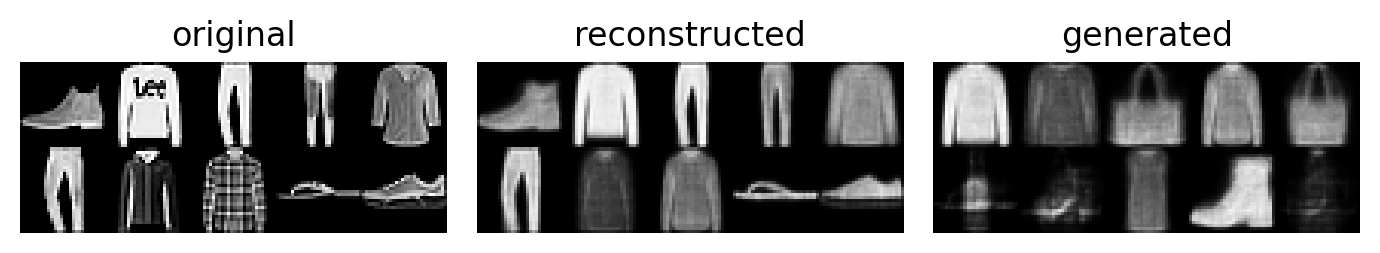

In [12]:
reconstructed = recover_image(vae, pics, num_samples=1)
generated = generate_image(vae, random_vector)
plot_digit_samples(original=pics.squeeze(), reconstucted=reconstructed, generated=generated)

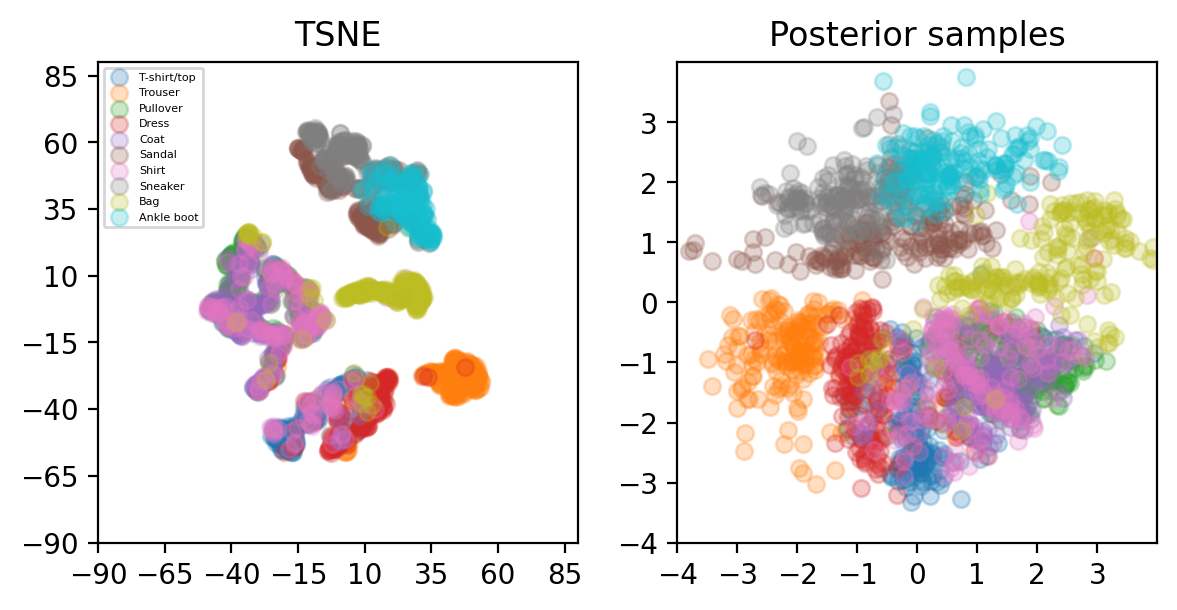

In [13]:
z_posterior = get_posterior_samples(model=vae, pics=whole_dataset.to(device), hidden_dim=hidden_dim, num_samples=1)
plot_posterior([whole_labels.numpy(), z_posterior.cpu().numpy()], names=val_loader.dataset.classes)

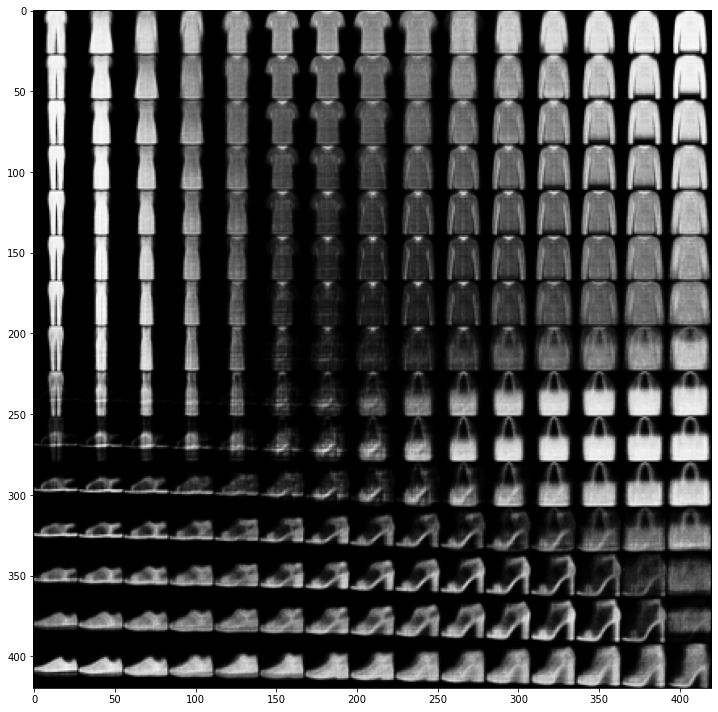

In [14]:
plot_pics_manifold(vae)

In [14]:
nll_vae = estimate_ll(vae, val_loader);

In [15]:
print(f"For VAE, LL estimation is {-np.mean(nll_vae)} +- {np.std(nll_vae)}")

For VAE, NLL estimation is -255.62214049275715 +- 0.012025860052546031


In [ ]:
# In 10 dimension:

In [15]:
nll_vae10 = estimate_ll(vae10, val_loader);

In [16]:
print(f"For VAE, LL estimation is {-np.mean(nll_vae10)} +- {np.std(nll_vae10)}")

For VAE, LL estimation is -238.5031243082682 +- 0.004965242467721569


# IWAE model

```python
model = IWAE(act_func=act_func['tanh'], num_samples=50)
trainer = pl.Trainer(gpus=1, deterministic=True)
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
```

Let us now move to more expressive models. The first one -- Importance Weighted Autoencoders, or IWAE


The idea is the following: instead of maximizing the previous ELBO, we will a closer bound to the log-likelihood, which corresponds to the $K$-samples importance weighting
estimate of the log-likelihood:

$$
\mathcal{L}_{\phi, \theta}^{\text{IWAE}}(X) = \frac{1}{N}  \sum_{i=1}^{N} \mathcal{L}_{\phi, \theta}^{\text{IWAE}}(x_i) = \frac{1}{N} \sum_{i=1}^{N} \mathbb{E}_{q_\phi(z|x_i)} \left( \frac{1}{K} \sum_{k=1}^{K} \log \frac{p_\theta(z_k, x_i)}{q_\phi(z_k|x_i)} \right) = \frac{1}{N} \sum_{i=1}^{N} \int_{z} q_\phi (z|x_i) \frac{1}{K} \sum_{k=1}^{K} \log \frac{p_\theta(z_k, x_i)}{q_\phi(z_k|x_i)} dz
$$

In [25]:
IWAE??

Init signature: IWAE(act_func, num_samples, hidden_dim, name='VAE')
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class IWAE(Base):
    def loss_function(self, recon_x, x, mu, logvar, z):
        log_Q = torch.distributions.Normal(loc=mu,
                                           scale=torch.exp(0.5 * logvar)).log_prob(z).view(
            (self.num_samples, -1, self.hidden_dim)).sum(-1)

        log_Pr = torch.sum((-0.5 * z ** 2).view((self.num_samples, -1, self.hidden_dim)), -1)
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction='none').view(
            (self.num_samples, -1, 784)).sum(-1)
        log_weight = log_Pr - BCE - log_Q
        log_weight = log_weight - torch.max(log_weight, 0)[0]  # for stability
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        weight = weight.detach()
        loss = torch.mean(torch.sum(weight * (-log_Pr + BCE +

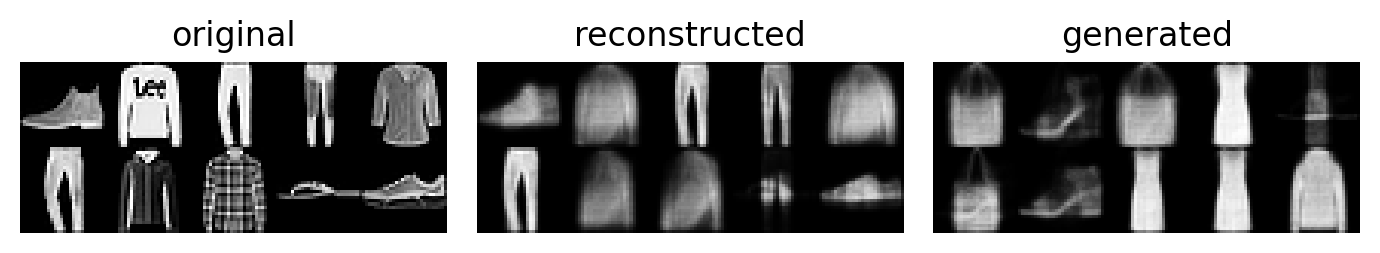

In [26]:
reconstructed = recover_image(iwae, pics)
generated = generate_image(iwae, random_vector)
plot_digit_samples(original=pics.squeeze(), reconstucted=reconstructed, generated=generated)

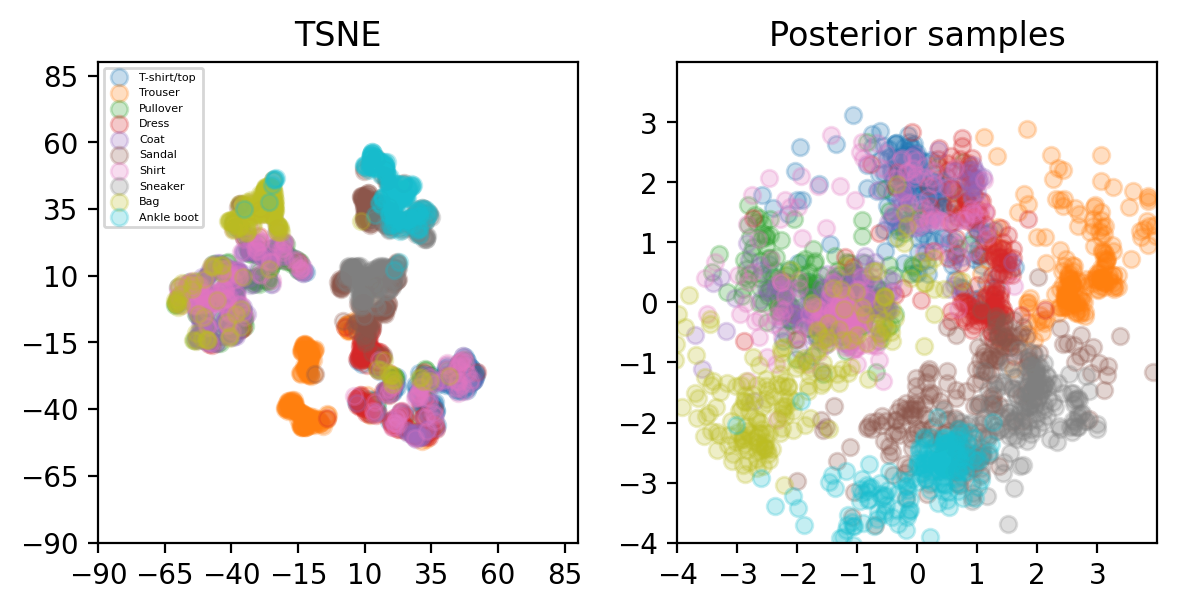

In [27]:
z_posterior = get_posterior_samples(model=iwae, pics=whole_dataset.to(device), hidden_dim=hidden_dim)
plot_posterior([whole_labels.numpy(), z_posterior.cpu().numpy()], names=val_loader.dataset.classes)

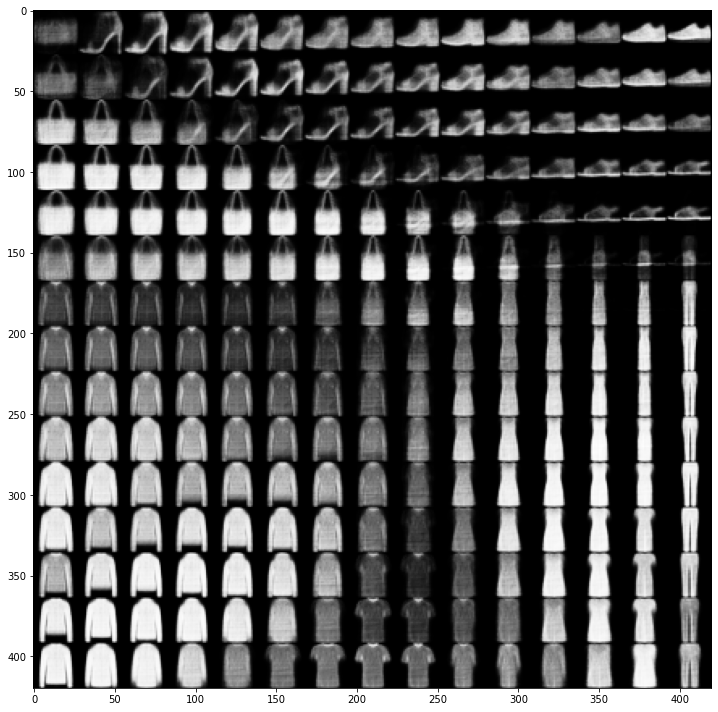

In [28]:
plot_pics_manifold(iwae)

In [29]:
nll_iwae = estimate_ll(iwae, val_loader);

In [30]:
print(f"For IWAE, LL estimation is {-np.mean(nll_iwae)} +- {np.std(nll_iwae)}")

For IWAE, LL estimation is -250.1601312764486 +- 0.007098778611126718


In [ ]:
# In 10 dimension:

In [17]:
nll_iwae10 = estimate_ll(iwae10, val_loader);

In [18]:
print(f"For IWAE, LL estimation is {-np.mean(nll_iwae10)} +- {np.std(nll_iwae10)}")

For IWAE, LL estimation is -239.22155863444013 +- 0.0057828352867898055


# VAE model with flows

The next idea of how we can improve on the variational family is the usage of Normalizing flows.

It works as follows: a composition of elementary transforms with tractable Jacobian determinant pushes an initial distribution into a more complex one.

Let us denote by $z$ -- the latent variable after the reparametrization trick. Then, we apply a transformation with tractable Jacobian.

$$
\tilde z = f_{\varphi}(z)
$$

We can also express new density in terms of the old one and logarithm of det Jacobian of the transformation:
$$
\log q_\varphi (\tilde z) = \log q(z) - \log |\det \text{Jac}_\varphi(z)| 
$$

Then, use it in the original ELBO.

In [9]:
VAE_with_flows??

Init signature:
VAE_with_flows(
    act_func,
    num_samples,
    hidden_dim,
    flow_type,
    num_flows,
    need_permute,
)
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class VAE_with_flows(Base):
    def __init__(self, act_func, num_samples, hidden_dim, flow_type, num_flows, need_permute):
        super(VAE_with_flows, self).__init__(act_func, num_samples, hidden_dim)
        self.Flow = NormFlow(flow_type, num_flows, hidden_dim, need_permute)
        self.name += f'_{flow_type}_{num_flows}'

    def loss_function(self, recon_x, x, mu, logvar, z, z_transformed, log_jac):
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction='none').view(
            (self.num_samples, -1, 784)).sum(-1).mean()
        log_Q = torch.distributions.Normal(loc=mu, scale=torch.exp(0.5 * logvar)).log_prob(z)
        log_Pr = (-0.5 * z_transformed ** 2)
        KLD = torch.mean((log_Q - log_Pr).view(
         

## RNVP

```python
model = VAE_with_flows(act_func=act_func['tanh'], num_samples=1, num_flows=2, flow_type="RNVP", need_permute=True)
trainer = pl.Trainer(gpus=1, deterministic=True)
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
```

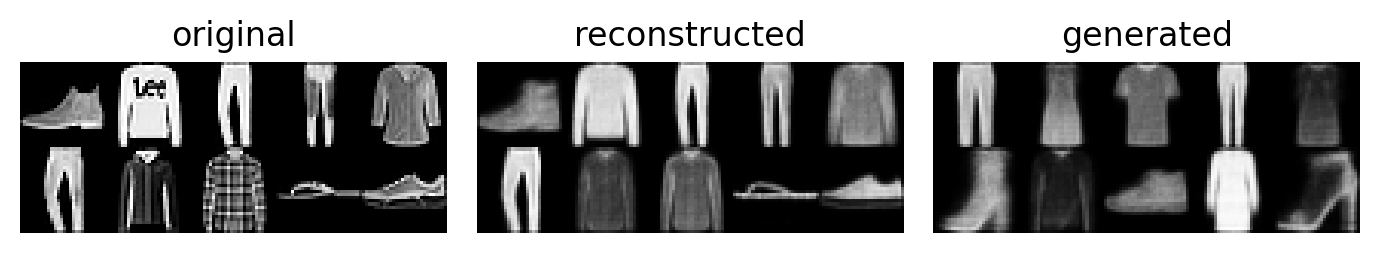

In [20]:
reconstructed = recover_image(vae_rnvp, pics, num_samples=1)
generated = generate_image(vae_rnvp, random_vector)
plot_digit_samples(original=pics.squeeze(), reconstucted=reconstructed, generated=generated)

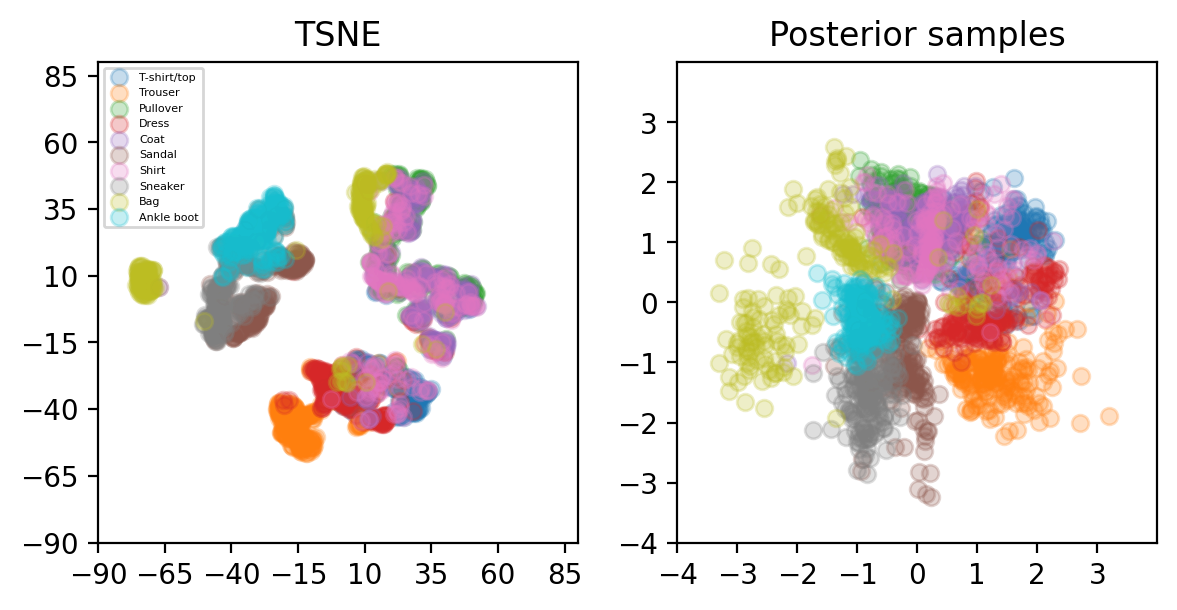

In [21]:
z_posterior = get_posterior_samples(model=vae_rnvp, pics=whole_dataset.to(device), num_samples=1, hidden_dim=hidden_dim)
plot_posterior([whole_labels.numpy(), z_posterior.cpu().numpy()], names=val_loader.dataset.classes)

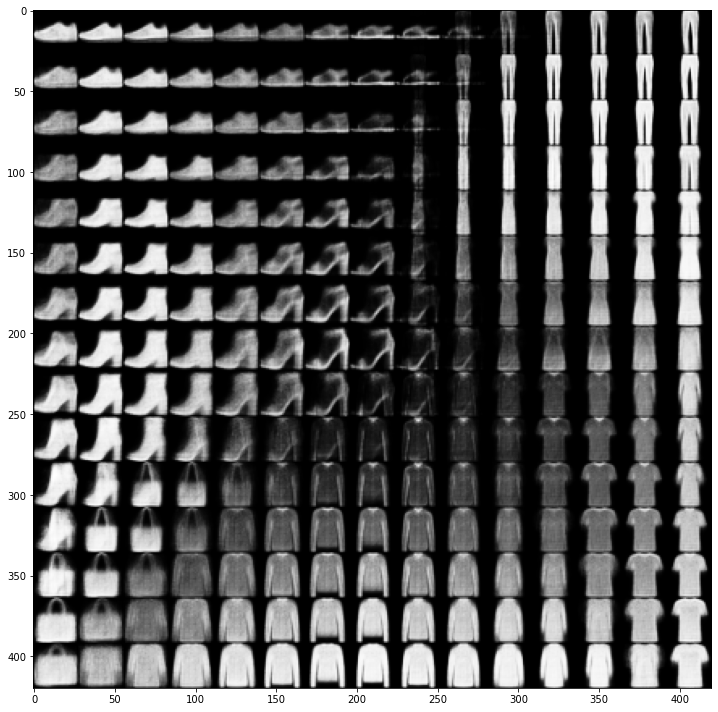

In [22]:
plot_pics_manifold(vae_rnvp)

In [23]:
nll_vae_rnvp = estimate_ll(vae_rnvp, val_loader)

In [24]:
print(f"For RNVP, LL estimation is {-np.mean(nll_vae_rnvp)} +- {np.std(nll_vae_rnvp)}")

For RNVP, LL estimation is -254.31534246826172 +- 0.0030300331273323397


# VAE with MCMC

The last idea -- add the MCMC method to improve the variational approximation.

The approach we consider utilizes an idea of decoupling training procedures for the encoder and decoder.

Specifically, we first perform the same optimization as in vanilla VAE, using the ELBO to update the parameters $\phi$ of the variational family (the encoder).

After that, we detach the latent sample obtained by the encoder and perform $K$ HMC steps targetting the true posterior distribution $p_\theta(z\mid x)$ from this point (here, $K=10$). After $K=10$ steps of HMC, we use the resulting sample to compute an estimate of the gradient of the likelihood (using Fisher's identity) and use that estimate to optimize over the decoder's parameters $\theta$.

In [42]:
VAE_MCMC??

Init signature:
VAE_MCMC(
    act_func,
    num_samples,
    hidden_dim,
    n_leapfrogs,
    step_size,
    use_barker,
)
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class VAE_MCMC(Base):
    def __init__(self, act_func, num_samples, hidden_dim, n_leapfrogs, step_size, use_barker):
        super(VAE_MCMC, self).__init__(act_func, num_samples, hidden_dim, name=f"VAE_MCMC_{n_leapfrogs}")
        self.sampler = HMC(n_leapfrogs=n_leapfrogs, step_size=step_size, use_barker=use_barker)

    def configure_optimizers(self):
        return [torch.optim.Adam(self.encoder_net.parameters(), lr=1e-3),
                torch.optim.Adam(self.decoder_net.parameters(),
                                 lr=1e-3)], []

    def loss_function(self, recon_x, x, mu, logvar, inference_part=False):
        if inference_part:
            BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784), reduction='none').view(
                (sel

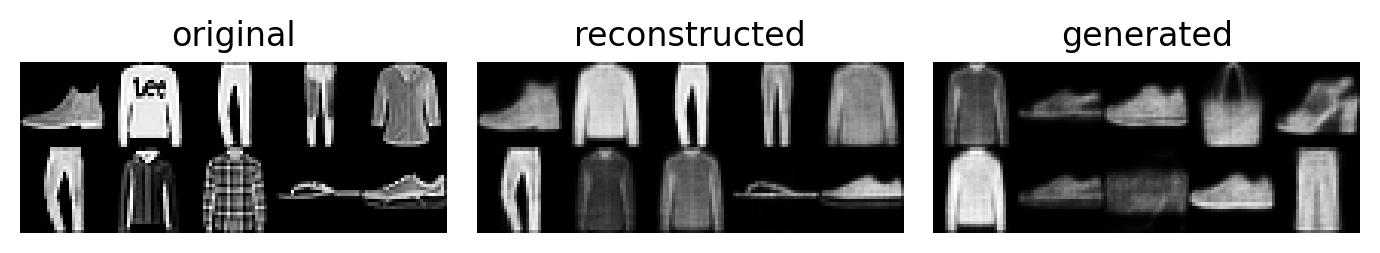

In [38]:
reconstructed = recover_image(vae_mcmc, pics, num_samples=1)
generated = generate_image(vae_mcmc, random_vector)
plot_digit_samples(original=pics.squeeze(), reconstucted=reconstructed, generated=generated)

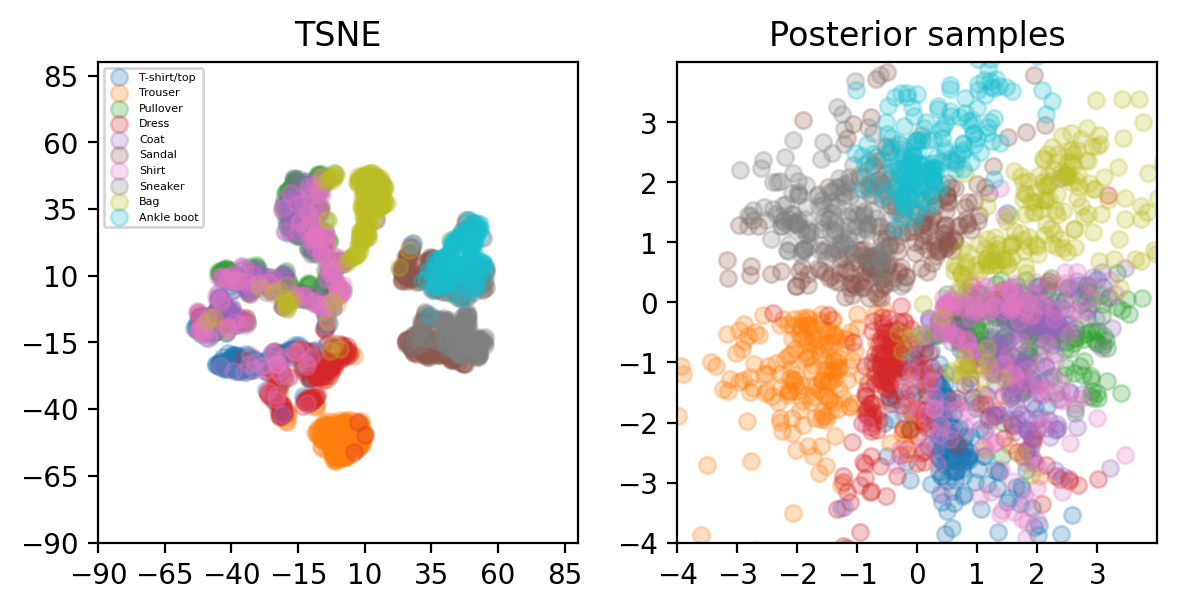

In [39]:
z_posterior = get_posterior_samples(model=vae_mcmc, pics=whole_dataset.to(device), num_samples=1, hidden_dim=hidden_dim)
plot_posterior([whole_labels.numpy(), z_posterior.cpu().numpy()], names=val_loader.dataset.classes)

In [40]:
nll_vae_mcmc = estimate_ll(vae_mcmc, val_loader)

In [41]:
print(f"For VAE with MCMC, LL estimation is {-np.mean(nll_vae_mcmc)} +- {np.std(nll_vae_mcmc)}")

For VAE with MCMC, NLL estimation is -255.28633180745442 +- 0.006070811130652288
